# Logistic Regression — From Scratch

A **line‑by‑line** NumPy implementation revealing exactly how binary logistic
regression works under the hood — no scikit‑learn shortcuts.


## 1. Quick Theory Recap

* **Model**

\[
P(y=1 \mid \mathbf{x};\,\theta) = \sigma(\mathbf{x}^{\top}\theta)
\quad\text{where}\quad
\sigma(z)=\frac{1}{1+e^{-z}}
\]

* **Loss (cross‑entropy)**  

\[
\mathcal{L}(\theta) =
-\frac{1}{N}\sum_{i=1}^{N}
\bigl[y_i \log\hat{y_i} + (1-y_i)\log(1-\hat{y_i})\bigr]
\]

* **Gradient**

\[
\nabla_\theta\mathcal{L} = \frac{1}{N}\mathbf{X}^{\top}(\hat{\mathbf{y}}-\mathbf{y})
\]

We’ll implement each formula explicitly in Python and iterate with **batch
gradient descent** until convergence.


### 2. Imports & synthetic data

In [26]:
# Standard scientific‑Python stack (no ML libraries)
import numpy as np
import matplotlib.pyplot as plt

# 2‑1. Fix the RNG seed so results are reproducible
np.random.seed(42)

# 2‑2. Ground‑truth line used to create our *fake* labels
TRUE_W = 3.0          # slope
TRUE_B = 0.5          # intercept

# 2‑3. Draw a single feature x uniformly from [-2, +2]
N_SAMPLES = 200
X = 4 * np.random.rand(N_SAMPLES, 1) - 2    # shape (N,1)

# 2‑4. Convert that x to probability via the *real* logistic model
logits = TRUE_W * X + TRUE_B
probs  = 1 / (1 + np.exp(-logits))          # sigmoid

# 2‑5. Sample a label y ~ Bernoulli(p)
y = (np.random.rand(N_SAMPLES, 1) < probs).astype(float)  # shape (N,1)

# 2‑6. Add a bias column (x0 ≡ 1) so θ₀ is learnable
X_b = np.c_[np.ones((N_SAMPLES, 1)), X]     # shape (N,2)

print(f"Design‑matrix shape: {X_b.shape}  |  Target shape: {y.shape}")

Design‑matrix shape: (200, 2)  |  Target shape: (200, 1)


### 3. Helper functions

In [27]:
# 3‑1. Sigmoid --------------------------------------------------------------
def sigmoid(z: np.ndarray) -> np.ndarray:
    '''
    Vectorised logistic function.

    Parameters
    ----------
    z : array‑like
        Real‑valued input (scalar, vector, or matrix).

    Returns
    -------
    ndarray
        σ(z) applied element‑wise.
    '''
    return 1.0 / (1.0 + np.exp(-z))

# 3‑2. Cross‑entropy loss ---------------------------------------------------
def loss(theta: np.ndarray, X: np.ndarray, y: np.ndarray) -> float:
    '''
    Compute average binary cross‑entropy (negative log‑likelihood).

    θ  = parameters column‑vector (shape (2,1))
    X  = design‑matrix with leading 1s (shape (N,2))
    y  = binary labels (shape (N,1))
    '''
    logits = X @ theta
    y_hat  = sigmoid(logits)

    # Avoid log(0) by clipping probabilities:
    eps = 1e-15
    y_hat = np.clip(y_hat, eps, 1 - eps)

    return float(-np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)))

# 3‑3. Gradient of the loss -------------------------------------------------
def gradient(theta: np.ndarray, X: np.ndarray, y: np.ndarray) -> np.ndarray:
    '''
    Analytical gradient ∇L = (1/N)·Xᵀ(ŷ−y).

    Returns the same shape as θ (2,1).
    '''
    y_hat = sigmoid(X @ theta)
    return X.T @ (y_hat - y) / len(X)

### 4. Training — batch gradient descent

In [28]:
# 4‑1. Hyper‑parameters
LEARNING_RATE = 0.1
MAX_ITERS     = 10_000
TOLERANCE     = 1e-6   # stop when gradient magnitude < this

# 4‑2. Parameter initialisation
theta = np.zeros((2, 1))    # start at origin [0, 0]^T

for step in range(MAX_ITERS):
    grad = gradient(theta, X_b, y)       # compute gradient
    theta -= LEARNING_RATE * grad        # gradient‑descent update

    # Optional: print loss occasionally
    if step % 1000 == 0:
        current_loss = loss(theta, X_b, y)
        print(f"step {step:5d}  |  loss = {current_loss:.4f}")

    # Early‑stop if the gradient is tiny (we're at/near optimum)
    if np.linalg.norm(grad) < TOLERANCE:
        print(f"Converged after {step} iterations")
        break

print("\nLearned parameters")
print("------------------")
print(f"θ₀ (bias)   = {theta[0,0]:.3f}")
print(f"θ₁ (weight) = {theta[1,0]:.3f}")

step     0  |  loss = 0.6724
step  1000  |  loss = 0.2860
step  2000  |  loss = 0.2860
Converged after 2976 iterations

Learned parameters
------------------
θ₀ (bias)   = 0.565
θ₁ (weight) = 2.687


### 5. Evaluation

In [29]:
# 5‑1. Convert probabilities → class predictions (threshold 0.5)
y_prob = sigmoid(X_b @ theta)
y_pred = (y_prob >= 0.5).astype(float)

# 5‑2. Accuracy (fraction of correct labels)
accuracy = np.mean(y_pred == y)

# 5‑3. Final loss (for curiosity)
final_loss = loss(theta, X_b, y)

print(f"Accuracy on training set : {accuracy:.3f}  "
      f"({accuracy*100:.1f} %)")
print(f"Final cross‑entropy loss : {final_loss:.4f}")

Accuracy on training set : 0.875  (87.5 %)
Final cross‑entropy loss : 0.2860


### 6. Visual sanity‑check

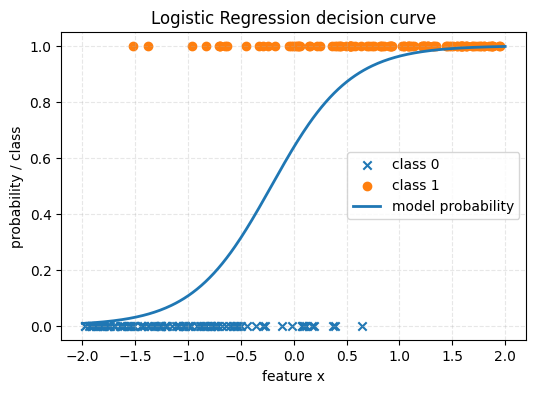

In [30]:
plt.figure(figsize=(6,4))

# Plot raw points (colour by true label)
plt.scatter(X[y[:,0]==0], y[y[:,0]==0], label="class 0", marker="x")
plt.scatter(X[y[:,0]==1], y[y[:,0]==1], label="class 1", marker="o")

# Decision curve — predicted P(y=1|x)
x_line = np.linspace(-2, 2, 300).reshape(-1,1)
x_line_b = np.c_[np.ones_like(x_line), x_line]
y_line = sigmoid(x_line_b @ theta)

plt.plot(x_line, y_line, label="model probability", linewidth=2)

plt.xlabel("feature x")
plt.ylabel("probability / class")
plt.ylim(-0.05, 1.05)
plt.title("Logistic Regression decision curve")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

### 7. Next steps

* **Regularisation** – add \(\lambda \|\theta\|^2\) to the loss for Ridge (L2) or
  \(\lambda \|\theta\|_1\) for Lasso (L1) to combat over‑fitting.  
* **Mini‑batch / Stochastic GD** – update on small slices of data; crucial for large
  datasets.  
* **Softmax generalisation** – extend the sigmoid to multi‑class classification.  
* **Bayesian Logistic Regression** – treat parameters as random variables and
  sample a posterior for calibrated uncertainty estimates.
